# 対戦型ロボット・シミュレータ

### ※Python の文法については「[Python を使ってみよう](https://github.com/ktysd/python-startup/wiki/2.-Python-%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%88%E3%81%86)」をご覧ください．

## 準備

In [1]:
from math import sin, cos, pi      #数学関数・定数のインポート
import numpy as np                 #数値計算機能のインポート 別名np
import matplotlib.pyplot as plt    #グラフ描画機能のインポート 別名plt
from ipywidgets import interact    #対話的処理機能のインポート
import numpy.linalg as la          #線形代数をインポート 別名la
from scipy.integrate import odeint #常微分方程式の解法をインポート
from matplotlib.animation import FuncAnimation #アニメーション機能のインポート
from matplotlib import rc          #各種設定機能のインポート
rc('animation', html='jshtml')     #Colabでアニメーション表示可能にするための設定

In [2]:
def U(x, s=100): #s=100 は丸め具合のデフォルト値
    '''
    丸めたステップ関数
    '''
    return (np.tanh(s*x/2) + 1)/2  #別定義．数値計算がオーバーフローしにくい
#    return 1/(1+np.exp(-s*x))     #式(10.10)　シグモイド関数

def sgn(x, s=1e4):
    '''
    丸めた符号関数
    '''

    return 2*U(x,s) - 1                       #式(11.4)

def trap(x, x0, w, s=100):
    '''
    丸めた台形関数
    '''

    return U(-(x-x0)+w, s) * U((x-x0)+w, s)   #式(11.8)

## 制御トルクの定義

In [3]:
def u_fight_R(t):
    '''
    右（青）の攻撃トルク
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

In [4]:
def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン制御）
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

In [5]:
def u_standing(state, a0=0, K3=15, K4=1):
    '''
    立位維持の状態フィードバック制御
    '''
    
    a, da, b, db = state
    
    #対戦用に，倒立制御のみ
    u = trap(b,0,bmax)*(K3*b + K4*db); 
    
    return u

## 運動方程式

### 反力の定義


In [6]:
def floor_force(state, Kp=1e4, Cp=90):
    '''
    床からの反力
    '''
    a, da, b, db = state

    #振り子先端の座標ベクトル
    xm = np.array([
        r*a+l*sin(b), 
        r+l*cos(b)
    ])

    #振り子先端の速度ベクトル
    dxm = np.array([
        r*da+l*db*cos(b),
        -l*db*sin(b)
    ])
    
    dxdt, y, dydt = dxm[0], xm[1], dxm[1] 
    
    #垂直抗力（ペナルティー法）
    R = U(-y) * (-Kp*y - Cp*dydt)

    #クーロン摩擦
    F = -sgn(dxdt) * mu * R

    return np.array([F, R])

In [7]:
def link_force(state, w0, ck=5000, cw=100):
    '''
    リンクからの反力
    ck, cw: リンク棒のばね定数，減衰係数
    '''

    a1, da1, b1, db1, a2, da2, b2, db2 = state 

    # 振子先端から先端への変位ベクトル
    ww = np.array([
        r*(a2-a1)+l*(sin(b2)-sin(b1)),
                  l*(cos(b2)-cos(b1))
    ])
    
      #その時間微分
    dww = np.array([
        r*(da2-da1)+l*( db2*cos(b2)-db1*cos(b1)),
                    l*(-db2*sin(b2)+db1*sin(b1))
    ])

    #リンクからの反力
    w = la.norm(ww)                         #wwの長さ
    dw = ( dww[0]*ww[0] + dww[1]*ww[1] )/w  #wwの長さの時間微分
    uu = ww/w                               #単位ベクトル化
    p = -ck*(w-w0) - cw*dw                  #反力の大きさ
    pp = p*uu                               #反力ベクトル

    return pp

In [8]:
def generalized_force(F, state, r, l):
    '''
    振り子先端への力を一般化力に変換する関数
    '''
    beta = state[2]
    #変換行列
    A = np.array([
        [r , 0],
        [l*cos(beta), -l*sin(beta)],
    ])

    return np.dot(A, F)   #式(11.12)

### 運動方程式の定義

#### 運動方程式の右辺

In [9]:
def right_hand_side(state, Fvec):
    '''
    運動方程式の右辺を計算する関数
    '''
    a, da, b, db = state
    
    A = np.array([
        [(M+m)*r**2+J, m*l*r*cos(b)],
        [m*l*r*cos(b),       m*l**2]
    ])
    
    bb = np.array([
        m*l*r*db**2 *sin(b),
        m*g*l*sin(b)
    ]) + Fvec     #Fvecは一般化力ベクトル
    
    # 線形方程式を解く
    invA = la.inv(A) #Aの逆行列
    hh = np.dot(invA, bb)
    
    return hh

#### 運動方程式の本体

In [10]:
# パラメータの設定（適当に定めた）
M, J, m, r, l = 2, 0.1, 5, 0.2, 1
g = 9.8             #重力加速度
mu = 0.3            #摩擦係数（今回は動摩擦係数＝静摩擦係数とみなす）
# Kp, Cp = 10000, 90  #床のばね定数，減衰係数
bmax = 0.9          #転倒角
w0 = 3              #リンクの自然長

def EOM(x, t):

    pp = link_force(x, w0)    #リンクからの反力

    #左の振子
    state = x[0:4] # = [ x[0], x[1], x[2], x[3] ]
    ff = floor_force(state);                   #床反力
    T  = u_standing(state, 0) + u_fight_L(t)   #倒立制御 + 攻撃トルク左
    Ff = generalized_force(ff-pp, state, r, l) #振り子先端への力→一般化力
    FT = np.array([T, -T])                     #トルク→一般化力
    Fall = Ff + FT                             #一般化力の総和
    hL = right_hand_side(state, Fall);         #加速度で整理した右辺

    #右の振子
    state = x[4:] # = [ x[4], x[5], x[6], x[7] ]
    ff = floor_force(state);                   #床反力
    T  = u_standing(state, 0) + u_fight_R(t)   #倒立制御 + 攻撃トルク右
    Ff = generalized_force(ff+pp, state, r, l) #振り子先端への力→一般化力
    FT = np.array([T, -T])                     #トルク→一般化力
    Fall = Ff + FT                             #一般化力の総和
    hR = right_hand_side(state, Fall);         #加速度で整理した右辺

    # 1階化した運動方程式の右辺
    dxdt = np.array([
        x[1],
        hL[0],
        x[3],
        hL[1],
        x[5],
        hR[0],
        x[7],
        hR[1]
    ])

    return dxdt

### 運動方程式の数値解

#### 時間軸の作成

In [11]:
t0 = 0    #初期時刻
dt = 0.01 #時間ステップ
tn = 1001 #データ長
t1 = t0 + dt*(tn-1) #終端時刻

ts = np.linspace(t0, t1, tn) #時間軸を表す等差数列
ts

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ])

#### 数値積分

In [12]:
x0 = np.array([
       0, 0, 0, 0,     #左側の初期状態
    w0/r, 0, 0, 0      #右側の初期状態
])
solution = odeint(EOM, x0, ts)      #運動方程式の数値解を求める
solution

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.98970713e-03,  3.96906643e-01, -4.53622129e-04, ...,
        -2.73001024e-05, -4.02610812e-06, -1.20575601e-03],
       [ 7.91715747e-03,  7.87521475e-01, -1.78941298e-03, ...,
        -2.19147203e-04, -3.17792213e-05, -4.69846818e-03],
       ...,
       [ 2.11031459e+01, -7.26021404e-02,  1.50944424e-02, ...,
         7.12647106e-05,  1.77960528e+00,  3.62239975e-05],
       [ 2.11024592e+01, -6.47364473e-02,  1.52327898e-02, ...,
         6.87415352e-05,  1.77960563e+00,  3.33924051e-05],
       [ 2.11018510e+01, -5.69154747e-02,  1.53554094e-02, ...,
         6.61925468e-05,  1.77960595e+00,  3.05699490e-05]])

#### 時間波形の確認


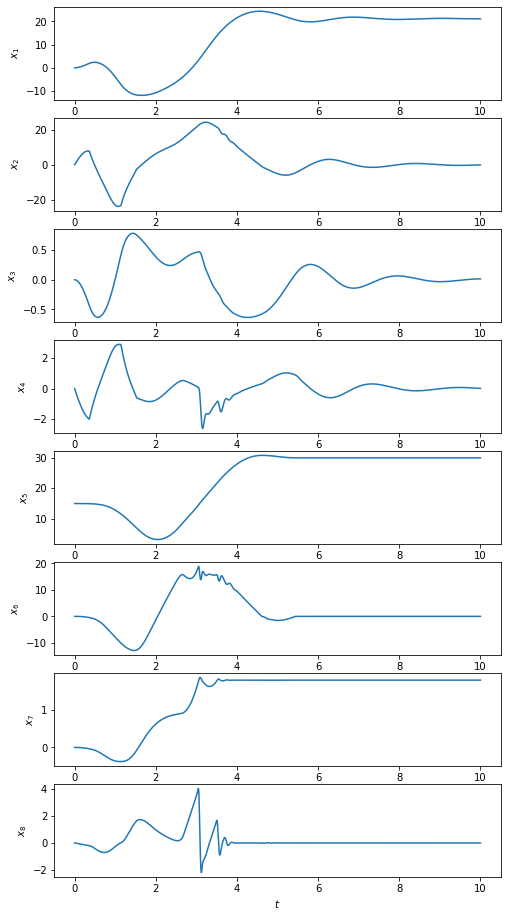

In [13]:
fig, axs= plt.subplots(8, 1, figsize=(8,16)) #グラフ用紙(axs)を4行,1列(4枚)用意

for i in range(8):
  ax = axs[i]
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x_%d$' %(i+1))

  xs = solution[:,i]
  ax.plot(ts, xs) 

### 数値解のアニメーション

#### アニメーション用のユーザー関数

In [14]:
def Rot(angle):
    '''
    回転行列
    '''
    R = np.array([
        [cos(angle), -sin(angle)],            
        [sin(angle),  cos(angle)],            
    ])

    return R

def get_points(state):
    '''
    特徴点の座標を取得する関数
    '''
    alpha, beta = state[0], state[2] #一般化座標の値
    x = r*alpha                      #水平変位
    xM = np.array([x, r])            #車輪の中心
    xm = np.array([x+l*sin(beta), r+cos(beta)]) #振り子の先端

    return (xM, xm)
    
def draw_wip(ax, state, color):
    '''
    振り子単体を描画する関数
    '''
    #一般化座標の値
    alpha, beta = state[0], state[2]

    #特徴点の座標
    xM, xm = get_points(state) #車輪の中心, 振り子の先端
        
    #振り子棒の描画
    ax.plot([xM[0], xm[0]], [xM[1], xm[1]], linewidth=3, color=color)

    #車輪の描画(n角形で近似)
    n = 5
    angles = np.linspace(0, 2*pi*(n-1)/n, n) #1周をn等分
    angles = np.append(angles, angles[0]) #終点＝始点を追加し，図形を閉じる 
    wheel = r * np.array(
        [np.cos(angles), np.sin(angles)]
    ) #数列を一括で三角関数するときは cos, sin の代わりに np.cos, np.sin

    moving_wheel = [] #Pythonの汎用リスト構造（空）
    for point in wheel.T:
        newpoint = np.dot(Rot(-alpha), point) #回転
        newpoint = newpoint + xM              #平行移動
        moving_wheel.append(newpoint) #リストに追加

    moving_wheel = np.array(moving_wheel) #リストをNumpy配列化

    ax.plot(moving_wheel[:, 0], moving_wheel[:, 1])


def display_motion(solution):
    '''
    アニメーションを作成する関数
    '''
    
    #数値解を10個おきに間引いて（時間方向）描画を軽くする
    skipped_solution = solution[::10,:] 

    #グラフ用紙の設定
    fig, ax= plt.subplots(1, 1, figsize=(8,3)) #グラフ用紙(ax)を1行,1列(1枚)用意
   
    #アニメーションの１コマの描画
    def each_frame(i):
        ax.cla() #グラフ用紙を白紙にリセット
        ax.set_xlim(-4,4) #x軸の範囲
        ax.set_ylim(-1,2) #y軸の範囲
        ax.grid()

        #i番目の数値解
        xL = skipped_solution[i,:4] #左
        xR = skipped_solution[i,4:] #右

        #水平変位を重心まわりに修正
        xML, xmL = get_points(xL) #（左）車輪の中心, 振り子の先端
        xMR, xmR = get_points(xR) #（右）車輪の中心, 振り子の先端
        xG = (#重心の座標
                M*(xML[0] + xMR[0]) + m*(xmL[0] + xmR[0])
             )/(2*M + 2*m)     

        xL[0] -= xG/r #重心から見た水平変位に対応する車輪角
        xR[0] -= xG/r #
        
        #振り子の描画
        draw_wip(ax, xL, 'r') #左は赤
        draw_wip(ax, xR, 'b') #右は青

        #連結棒の描画（緑）
        xML, xmL = get_points(xL) # 新しい一般化座標で取り直し
        xMR, xmR = get_points(xR) #
        ax.plot(
            [xmL[0], xmR[0]], #先端の各X座標
            [xmL[1], xmR[1]], #先端の各Y座標
            linewidth=3, color='g'
        )

    #アニメーションデータの作成
    anim = FuncAnimation(
        fig, 
        each_frame,
        interval=80,
        frames=len(skipped_solution)
    )
  
    return anim

#### (7) 数値解のアニメーション表示

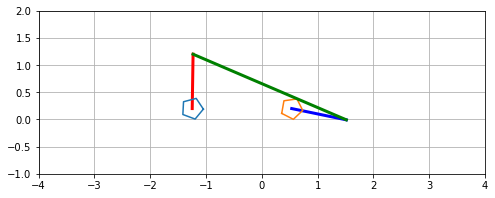

In [15]:
display_motion(solution)

### 実習4.1
- 実習3.5は，上記の実行例で完了しています．

# 問題4.1

左(赤)のロボットのバンバン入力 `u_fight_L` の切替時刻や段数を調整して，

1. 左 ( 赤 ) の勝ち
2. 右 ( 青 ) の勝ち
3. 引き分け
4. 共倒れ

を全て再現せよ．対応するバンバン入力を，数式と数値で記録せよ．

※以下は，条件変更に必要な処理を集めたものです．処理内容は上記と同じです．

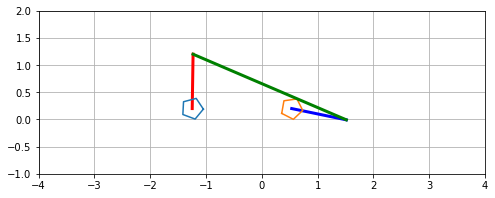

In [17]:
def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン）　この関数の中身を書き換える！
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

def u_fight_R(t):
    '''
    右（青）の攻撃トルク　こちらは書き換えない！
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

solution = odeint(EOM, x0, ts)   #運動方程式の数値解を求める
display_motion(solution)         #アニメーション表示

### <font color=red>※以下は，書き換えに必要な処理を抜粋したものです．以下を実行する前に，以上を実行しておく必要があります．</font>

### ※Python の文法については「[Python を使ってみよう](https://github.com/ktysd/python-startup/wiki/2.-Python-%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%88%E3%81%86)」をご覧ください．

## 問題4.1

次のコードセルにおいて，左(赤)のロボットのバンバン入力 `u_fight_L` の切替時刻や段数を調整して，

1. 左 ( 赤 ) の勝ち
2. 右 ( 青 ) の勝ち
3. 引き分け
4. 共倒れ

を全て再現せよ．対応するバンバン入力を，数式と数値で記録せよ．

In [ ]:
def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン）　この関数の中身を書き換える！
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

def u_fight_R(t):
    '''
    右（青）の攻撃トルク　こちらは書き換えない！
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

solution = odeint(EOM, x0, ts)   #運動方程式の数値解を求める
display_motion(solution)         #アニメーション表示

## 問題4.2

次のコードセルにおいて，左 ( 赤 ) のロボットが勝利し，なおかつ勝利 ( 右 ( 青 ) のロボットの先端が床に触れる ) までの所要時間が最短となるような，バンバン入力を構成せよ．

In [ ]:
def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン）　この関数の中身を書き換える！
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

def u_fight_R(t):
    '''
    右（青）の攻撃トルク　こちらは書き換えない！
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

solution = odeint(EOM, x0, ts)   #運動方程式の数値解を求める
display_motion(solution)         #アニメーション表示

## 問題4.3

次のコードセルにおいて，左 ( 赤 ) のロボットが勝利し，なおかつ右 ( 青 ) のロボットが左側に倒れるような，バンバン入力を構成せよ．

In [ ]:
def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン）　この関数の中身を書き換える！
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

def u_fight_R(t):
    '''
    右（青）の攻撃トルク　こちらは書き換えない！
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

solution = odeint(EOM, x0, ts)   #運動方程式の数値解を求める
display_motion(solution)         #アニメーション表示

## 問題4.4

支給プログラム double wip.ipynb では，右 ( 青 ) 用のバンバン入力 `u_fight_R` は空であり，左 ( 赤 ) が勝利した．

次のコードセルにおいて，`u_fight_R` に何らかの処理を追加して，左 ( 赤 ) に勝て．ただし，次のルールに従うこととする．

* `u_fight_R` 以外は書き換えない．
* `u_fight_R` にはどんな処理を書いてもよい．※Python の文法には従う．

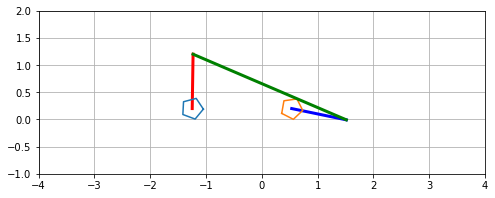

In [20]:
def u_fight_R(t):
    '''
    右（青）の攻撃トルク　今度は，こっちを書き換える！
    '''

    #現状 0 = 何もしない
    u = 0;  
    
    return u

def u_fight_L(t):
    '''
    左（赤）の攻撃トルク（バンバン）　こちらは書き換えない！
    '''

    P = 6; #バンバン入力の強度
    
    # 以下は3段の場合
    t1, t2, t3 = 0.36, 0.78, 0.39; #切替時間の変更は0.01単位
    if t < t1:
        u = P
    elif t < t1+t2:
        u = -P
    elif t < t1+t2+t3:
        u = P
    else:
        u = 0

    return u

solution = odeint(EOM, x0, ts)   #運動方程式の数値解を求める
display_motion(solution)         #アニメーション表示